In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from glob import glob
import pathlib
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

In [2]:
DATA_DIR = '../data/raw'

In [3]:
df = {}
test_df = None
for fpath in glob(DATA_DIR + '/*.csv'):
    p = pathlib.PurePath(fpath)
    fname = p.parts[-1]
    if fname == 'test.csv':    # Create test DataFrame separately
        test_df = pd.read_csv(fpath)
    elif fname == 'sample_submission.csv':    # Ignore the sample_submission.csv
        pass
    else:
        df[p.parts[-1]] = pd.read_csv(fpath)
NUM_TOPICS = len(df)

## Data structure
What do the files look like? (Yes, this is more or less explained on the Kaggle data page for the competition, but good habit to have) 

In [4]:
df['biology.csv'].head(5)

,id,title,content,tags
0,1,What is the criticality of the ribosome bindin...,"<p>In prokaryotic translation, how critical fo...",ribosome binding-sites translation synthetic-b...
1,2,How is RNAse contamination in RNA based experi...,<p>Does anyone have any suggestions to prevent...,rna biochemistry
2,3,Are lymphocyte sizes clustered in two groups?,<p>Tortora writes in <em>Principles of Anatomy...,immunology cell-biology hematology
3,4,How long does antibiotic-dosed LB maintain goo...,<p>Various people in our lab will prepare a li...,cell-culture
4,5,Is exon order always preserved in splicing?,<p>Are there any cases in which the splicing m...,splicing mrna spliceosome introns exons


In [5]:
display(HTML('<blockquote>' + df['biology.csv'].content[0] + '</blockquote>'))

Content looks to be just the stackoverflow question. This could be be confirmed more careful analysis but once again the Kaggle data description page clarifies it.

## Tag Data Exploration

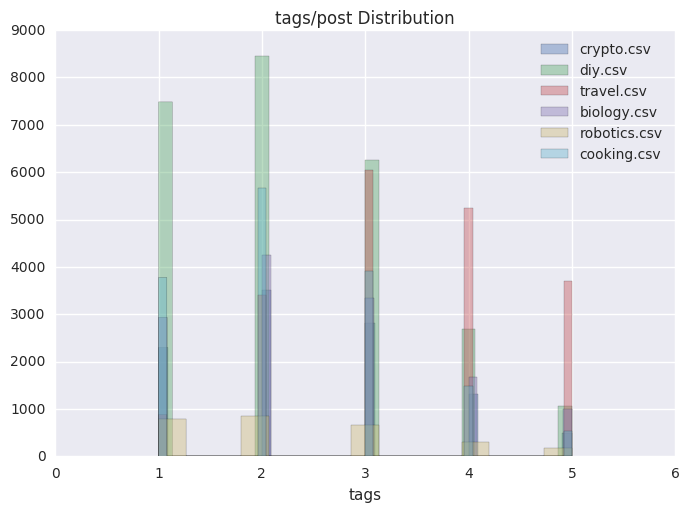

In [6]:
post_tag_counts = {k: df[k]['tags'].apply(lambda x: len(x.split(' '))) for k in df.keys()}
ax = None
for k, v in post_tag_counts.items():
    sns.distplot(v, label=k, kde=False)
plt.title('tags/post Distribution');
plt.gca().legend(loc='upper right');

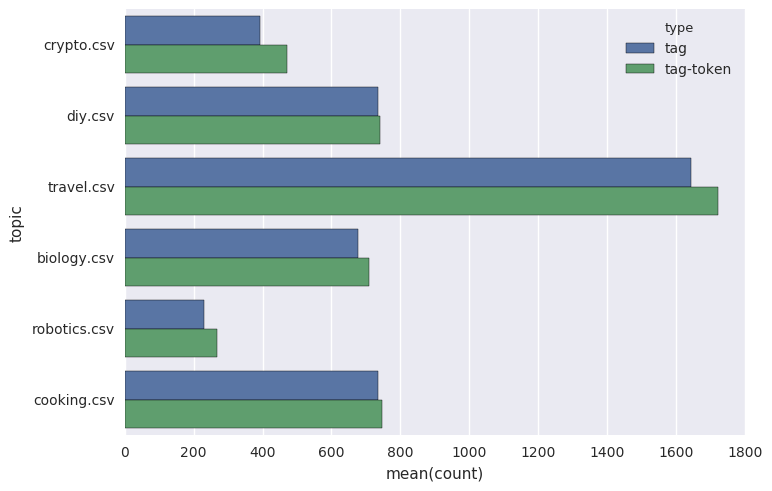

In [7]:
tags = {k: pd.Series(e for r in df[k]['tags'] for e in r.split(' ')).drop_duplicates() for k in df.keys()}
tag_tokens = {k: pd.Series(e for r in tags[k] for e in r.split('-')).drop_duplicates() for k in df.keys()}

sns.barplot(
    x='count',
    y='topic',
    hue='type',
    data=pd.DataFrame({'type': t, 'topic': k, 'count': len(d[k])}
                      for t, d in zip(('tag', 'tag-token'), (tags, tag_tokens))
                      for k in d.keys())
);

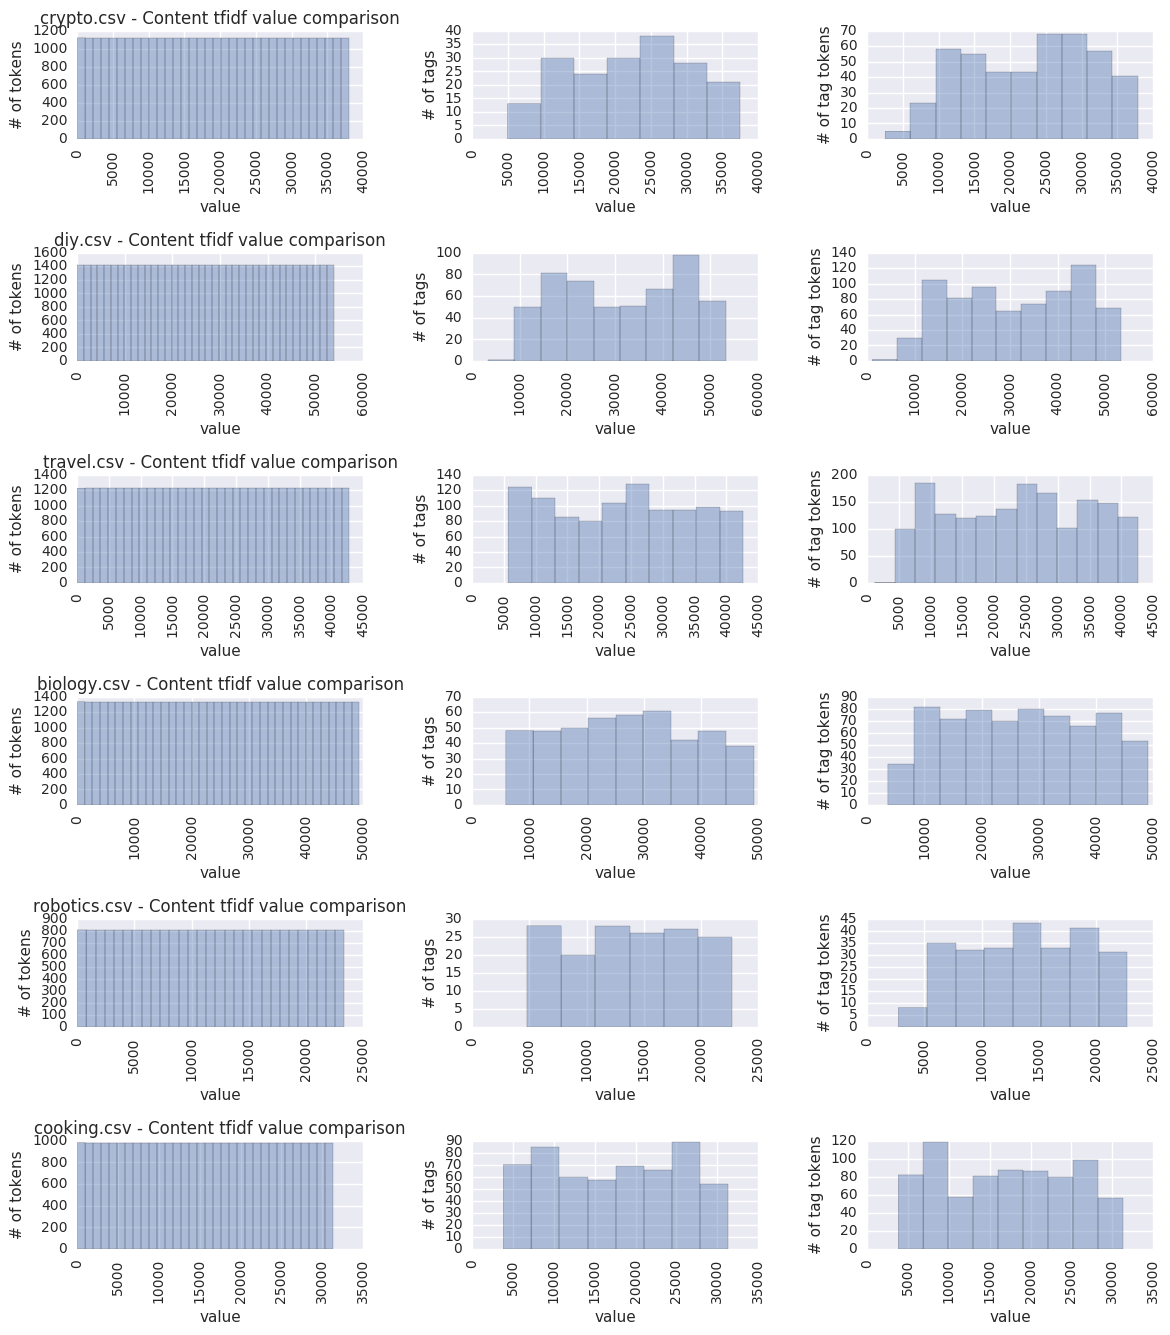

In [8]:
tfidf_content_vectorizer = {k: TfidfVectorizer() for k in df.keys()}
tfidf_content_matrix = {}
for k, vectorizer in tfidf_content_vectorizer.items():
    tfidf_content_matrix[k] = vectorizer.fit_transform(df[k]['content'])

tag_content_tfidf_value = {
    k: pd.DataFrame([
            {'token': t, 'value': v} for t, v in tfidf_content_vectorizer[k].vocabulary_.items()
        ]) for k in df.keys()
    }

plt.figure(figsize=(12, 2.25 * NUM_TOPICS))
for i, k in enumerate(df.keys()):
    ax = plt.subplot(NUM_TOPICS, 3, 3 * i + 1)
    plt.title('%s - Content tfidf value comparison' % k);
    sns.distplot(tag_content_tfidf_value[k]['value'], kde=False)
    plt.tight_layout()
    plt.ylabel('# of tokens');
    plt.xticks(rotation='vertical');

    plt.subplot(NUM_TOPICS, 3, 3 * i + 2, sharex=ax)
    sns.distplot(pd.merge(tags[k].to_frame(name='token'), tag_content_tfidf_value[k], on='token')['value'], kde=False)
    plt.tight_layout()
    plt.ylabel('# of tags');
    plt.xticks(rotation='vertical');
    
    plt.subplot(NUM_TOPICS, 3, 3 * i + 3, sharex=ax)
    sns.distplot(pd.merge(tag_tokens[k].to_frame(name='token'), tag_content_tfidf_value[k], on='token')['value'], kde=False)
    plt.tight_layout()
    plt.ylabel('# of tag tokens');
    plt.xticks(rotation='vertical');

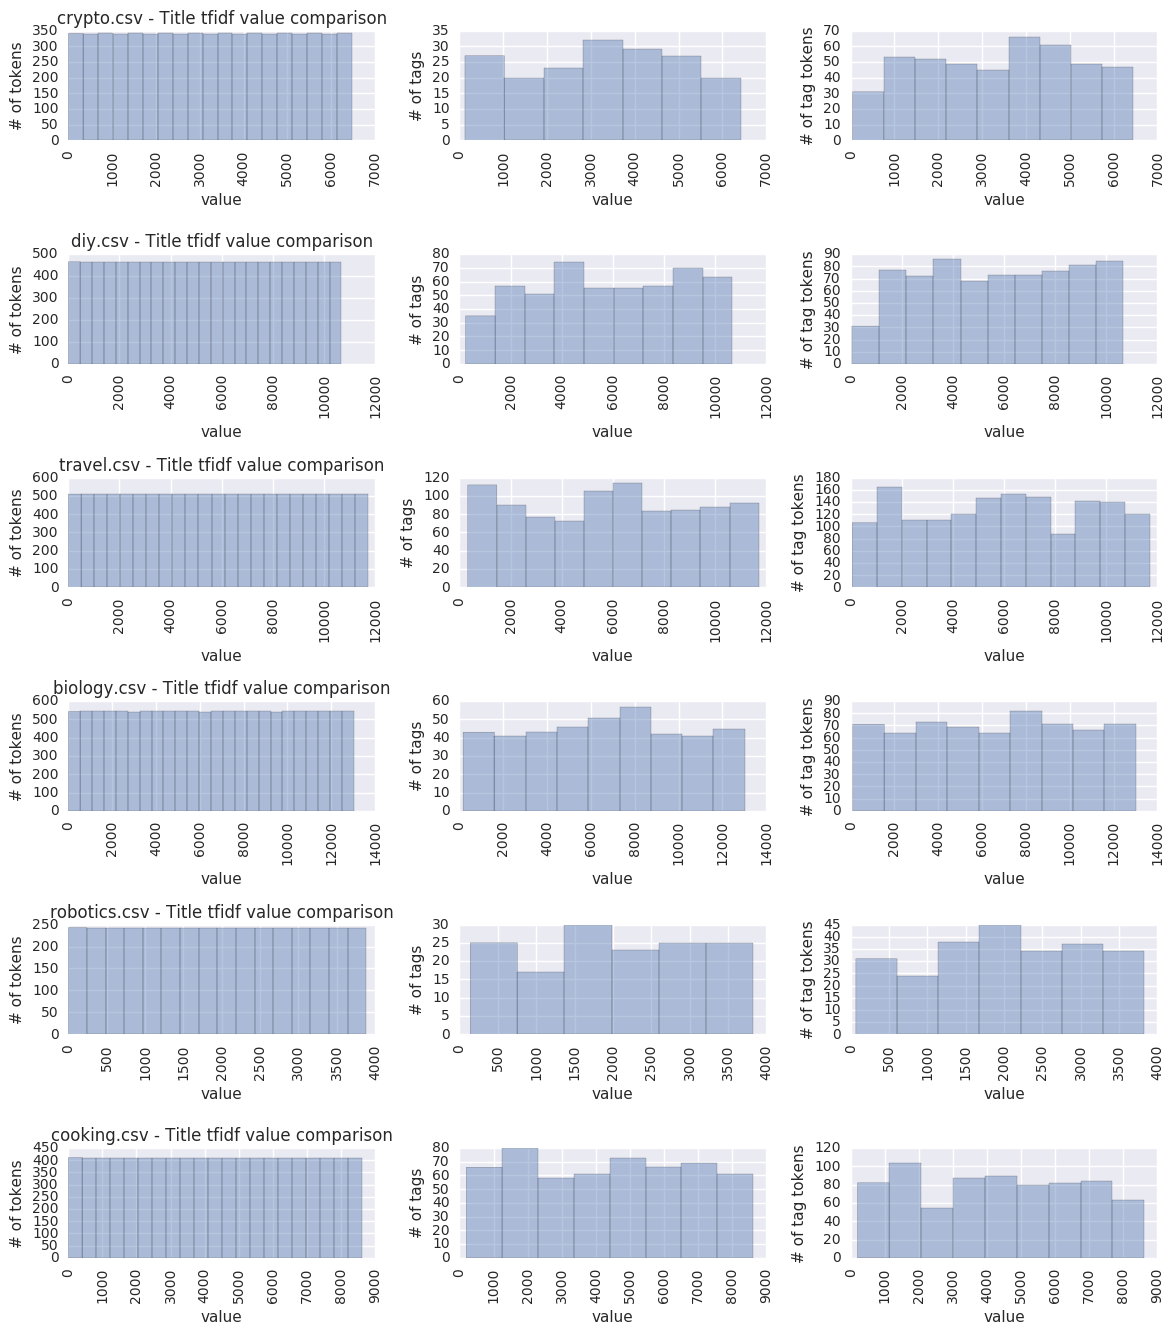

In [9]:
tfidf_title_vectorizer = {k: TfidfVectorizer() for k in df.keys()}
tfidf_title_matrix = {}
for k, vectorizer in tfidf_title_vectorizer.items():
    tfidf_title_matrix[k] = vectorizer.fit_transform(df[k]['title'])

tag_title_tfidf_value = {
    k: pd.DataFrame([
            {'token': t, 'value': v} for t, v in tfidf_title_vectorizer[k].vocabulary_.items()
        ]) for k in df.keys()
    }

plt.figure(figsize=(12, 2.25 * NUM_TOPICS))
for i, k in enumerate(df.keys()):
    ax = plt.subplot(NUM_TOPICS, 3, 3 * i + 1)
    plt.title('%s - Title tfidf value comparison' % k);
    sns.distplot(tag_title_tfidf_value[k]['value'], kde=False)
    plt.tight_layout()
    plt.ylabel('# of tokens');
    plt.xticks(rotation='vertical');

    plt.subplot(NUM_TOPICS, 3, 3 * i + 2, sharex=ax)
    sns.distplot(pd.merge(tags[k].to_frame(name='token'), tag_title_tfidf_value[k], on='token')['value'], kde=False)
    plt.tight_layout()
    plt.ylabel('# of tags');
    plt.xticks(rotation='vertical');
    
    plt.subplot(NUM_TOPICS, 3, 3 * i + 3, sharex=ax)
    sns.distplot(pd.merge(tag_tokens[k].to_frame(name='token'), tag_title_tfidf_value[k], on='token')['value'], kde=False)
    plt.tight_layout()
    plt.ylabel('# of tag tokens');
    plt.xticks(rotation='vertical');

In [10]:
all_tfidf_vectorizer = TfidfVectorizer().fit(
    pd.concat([v['content'] for v in df.values()] + [v['title'] for v in df.values()])
)

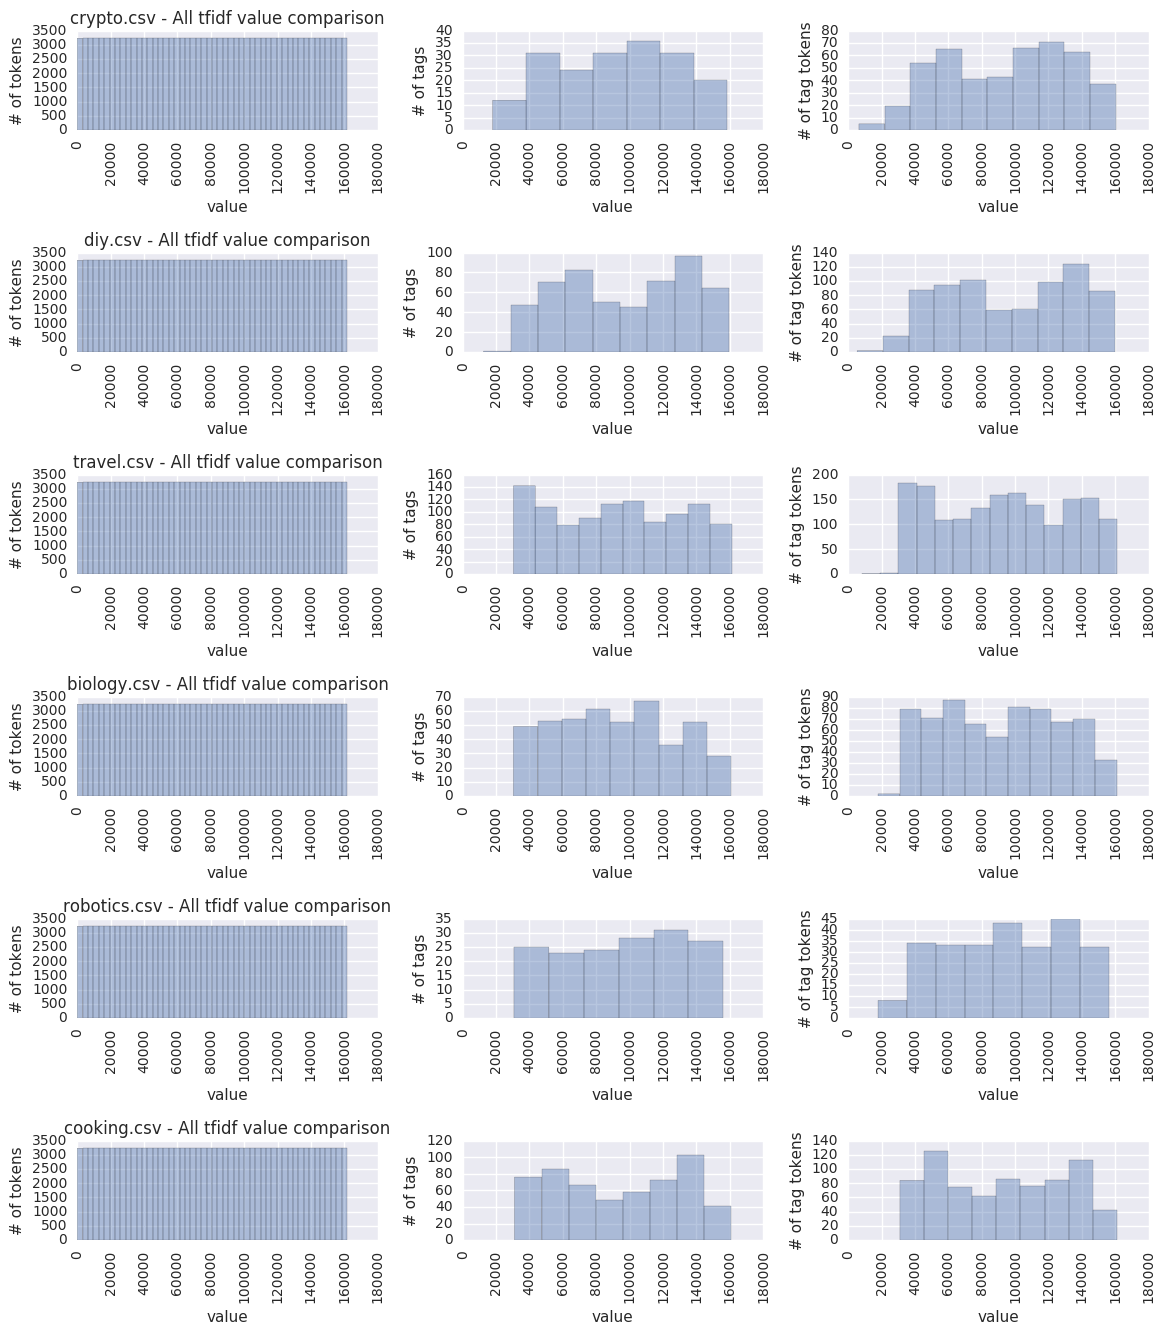

In [11]:
tag_all_tfidf_value = pd.DataFrame([
        {'token': t, 'value': v} for t, v in all_tfidf_vectorizer.vocabulary_.items()
    ])

plt.figure(figsize=(12, 2.25 * NUM_TOPICS))
for i, k in enumerate(df.keys()):
    ax = plt.subplot(NUM_TOPICS, 3, 3 * i + 1)
    plt.title('%s - All tfidf value comparison' % k);
    sns.distplot(tag_all_tfidf_value['value'], kde=False)
    plt.tight_layout()
    plt.ylabel('# of tokens');
    plt.xticks(rotation='vertical');

    plt.subplot(NUM_TOPICS, 3, 3 * i + 2, sharex=ax)
    sns.distplot(pd.merge(tags[k].to_frame(name='token'), tag_all_tfidf_value, on='token')['value'], kde=False)
    plt.tight_layout()
    plt.ylabel('# of tags');
    plt.xticks(rotation='vertical');
    
    plt.subplot(NUM_TOPICS, 3, 3 * i + 3, sharex=ax)
    sns.distplot(pd.merge(tag_tokens[k].to_frame(name='token'), tag_all_tfidf_value, on='token')['value'], kde=False)
    plt.tight_layout()
    plt.ylabel('# of tag tokens');
    plt.xticks(rotation='vertical');

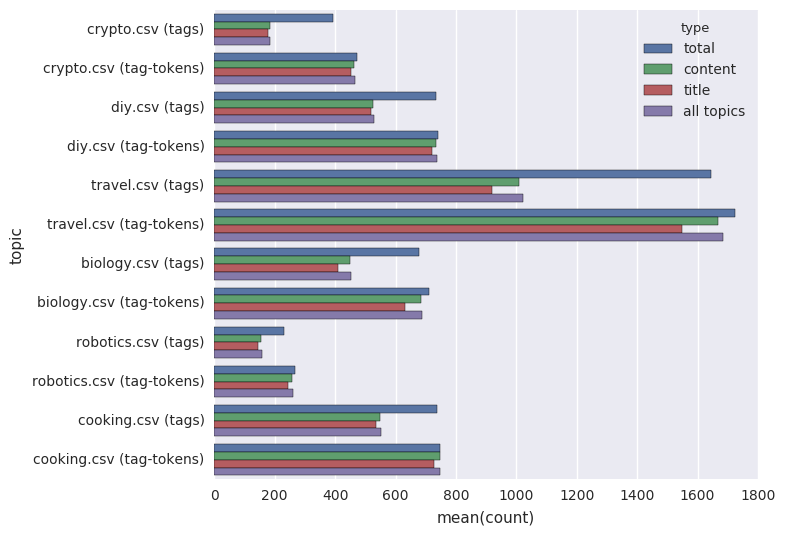

In [20]:
tfidf_types = ((tfidf_content_vectorizer, 'content'),
               (tfidf_title_vectorizer, 'title'), 
               (all_tfidf_vectorizer, 'all topics'))
tmp_data = [
    e
    for k in df.keys()
    for e in [{
        'topic': k + ' (tags)',
        'count': len(tags[k]),
        'type': 'total',
    },{
        'topic': k + ' (tag-tokens)',
        'count': len(tag_tokens[k]),
        'type': 'total',
    }]
    ]
for k, tfidf_type in itertools.product(df.keys(), tfidf_types):
    tfidf = tfidf_type[0]
    corpus_type = tfidf_type[1]
    # There are more efficient ways to do this
    try:
        vocab = pd.DataFrame([
            {'token': t, 'value': v} for t, v in tfidf[k].vocabulary_.items()
        ])
    except TypeError:
        vocab = pd.DataFrame([
            {'token': t, 'value': v} for t, v in tfidf.vocabulary_.items()
        ])        
    tmp_data.extend([{
            'topic': k + ' (tags)',
            'count': len(pd.merge(tags[k].to_frame(name='token'), vocab, on='token')),
            'type': corpus_type,                       
        },{
            'topic': k + ' (tag-tokens)',
            'count': len(pd.merge(tag_tokens[k].to_frame(name='token'), vocab, on='token')),
            'type': corpus_type,
        }])
sns.barplot(y='topic', x='count', hue='type', data=pd.DataFrame(tmp_data));
plt.tight_layout();